In [9]:
from keras.applications import Xception
model=Xception


In [10]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

In [11]:
import os
import cv2
from tqdm import tqdm  # To show progress bar during the image loading process

# Paths to 'yes' and 'no' folders
yes_folder = "Data/Tumor"
no_folder = "Data/Normal"

# Initialize lists to store images and labels
X = []
y = []

# Function to load images from a given folder and label them
def load_images_from_folder(folder, label):
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:  # Check if the image was loaded successfully
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(label)
        else:
            print(f"Warning: Could not load image {img_name}")

# Load images from 'yes' folder (Tumor present)
print("Loading images from 'yes' folder...")
load_images_from_folder(yes_folder, 'Y')

# Load images from 'no' folder (No tumor)
print("Loading images from 'no' folder...")
load_images_from_folder(no_folder, 'N')

# Check the length of images and labels
print(f"Number of images: {len(X)}")
print(f"Number of labels: {len(y)}")

Loading images from 'yes' folder...


 16%|█▌        | 3013/18607 [00:01<00:11, 1363.10it/s]

100%|██████████| 18607/18607 [00:11<00:00, 1619.80it/s]


Loading images from 'no' folder...


100%|██████████| 3066/3066 [00:01<00:00, 1733.99it/s]

Number of images: 21672
Number of labels: 21672


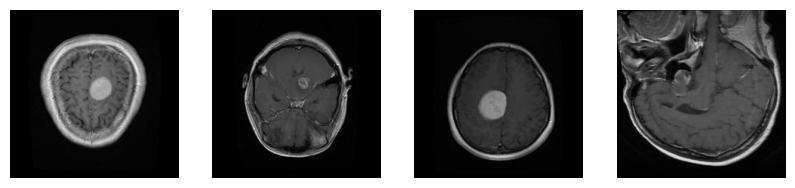

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [14]:
#preprocessing steps
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [15]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (14520, 224, 224, 3)
X_test Shape:  (7152, 224, 224, 3)
y_train Shape:  (14520, 2)
y_test Shape:  (7152, 2)


In [17]:



img_rows, img_cols = 224, 224


xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))


# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in xception.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(xception.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

83683744/83683744 [==============================] - 39s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 SeparableConv2D False
8 BatchNormalization False
9 Activation False
10 SeparableConv2D False
11 BatchNormalization False
12 Conv2D False
13 MaxPooling2D False
14 BatchNormalization False
15 Add False
16 Activation False
17 SeparableConv2D False
18 BatchNormalization False
19 Activation False
20 SeparableConv2D False
21 BatchNormalization False
22 Conv2D False
23 MaxPooling2D False
24 BatchNormalization False
25 Add False
26 Activation False
27 SeparableConv2D False
28 BatchNormalization False
29 Activation False
30 SeparableConv2D False
31 BatchNormalization False
32 Conv2D False
33 MaxPooling2D False
34 BatchNormalization False
35 Add False
36 Activation False
37 SeparableConv2D False
38 BatchNormalization False
39 Activation False
40 SeparableConv2D False
41 BatchNormalization F

In [18]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 2

FC_Head = lw(xception, num_classes)

model = Model(inputs = xception.input, outputs = FC_Head)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [20]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [21]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
454/454 [==============================] - 798s 2s/step - loss: 0.4156 - accuracy: 0.8854 - val_loss: 0.2231 - val_accuracy: 0.9093
Epoch 2/5
454/454 [==============================] - 918s 2s/step - loss: 0.2106 - accuracy: 0.9179 - val_loss: 0.1831 - val_accuracy: 0.9304
Epoch 3/5
454/454 [==============================] - 803s 2s/step - loss: 0.1731 - accuracy: 0.9333 - val_loss: 0.2618 - val_accuracy: 0.9104
Epoch 4/5
454/454 [==============================] - 1016s 2s/step - loss: 0.1488 - accuracy: 0.9393 - val_loss: 0.1993 - val_accuracy: 0.9174
Epoch 5/5
454/454 [==============================] - 1450s 3s/step - loss: 0.1283 - accuracy: 0.9494 - val_loss: 0.1705 - val_accuracy: 0.9404


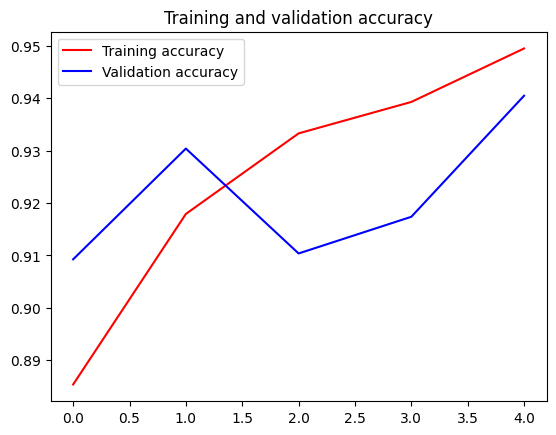

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

224/224 [==============================] - 214s 952ms/step


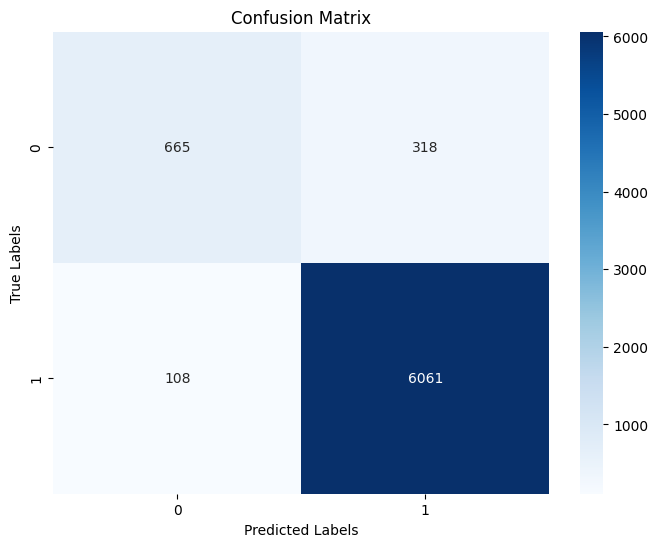

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Precision
precision = precision_score(y_true, y_pred_classes)

# Recall
recall = recall_score(y_true, y_pred_classes)

# F1 Score
f1 = f1_score(y_true, y_pred_classes)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Classification report
report = classification_report(y_true, y_pred_classes, target_names=['No Tumor', 'Tumor'])
print(report)


Accuracy: 0.9404
Precision: 0.9501
Recall: 0.9825
F1 Score: 0.9661
              precision    recall  f1-score   support

    No Tumor       0.86      0.68      0.76       983
       Tumor       0.95      0.98      0.97      6169

    accuracy                           0.94      7152
   macro avg       0.91      0.83      0.86      7152
weighted avg       0.94      0.94      0.94      7152

